In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.svm import SVC

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import _tree

import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.5])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [3]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index = [1,2,3,4], columns = [1,2,3,4])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

In [4]:
df = pd.read_csv("US_Accidents_Dec20_updated_cleaned_imputed_data_prepared.csv")

In [5]:
X, y = df.drop(["Severity"], axis=1), df["Severity"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
cols_to_scale = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

In [8]:
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

<ipython-input-8-22cd63f610dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
/home/luay/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-8-22cd63f610dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

# KNN Classifier

### It takes a _very_ long time to compute all 1.5 million rows, so we select a subset to evaluate

In [92]:
num_per_class_train = 100000
num_per_class_test = 1000

In [93]:
X_train_ones = X_train[y_train==1][:num_per_class_train]
y_train_ones = y_train[y_train==1][:num_per_class_train]

X_train_twos = X_train[y_train==2][:num_per_class_train]
y_train_twos = y_train[y_train==2][:num_per_class_train]

X_train_threes = X_train[y_train==3][:num_per_class_train]
y_train_threes = y_train[y_train==3][:num_per_class_train]

X_train_fours = X_train[y_train==4][:num_per_class_train]
y_train_fours = y_train[y_train==4][:num_per_class_train]

X_subset_train = np.concatenate((X_train_ones, X_train_twos, X_train_threes, X_train_fours), axis=0)
y_subset_train = np.concatenate((y_train_ones, y_train_twos, y_train_threes, y_train_fours), axis=0)

In [94]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
_ = knn.fit(X_subset_train, y_subset_train)

In [95]:
X_test_ones = X_test[y_test==1][:num_per_class_test]
y_test_ones = y_test[y_test==1][:num_per_class_test]

X_test_twos = X_test[y_test==2][:num_per_class_test]
y_test_twos = y_test[y_test==2][:num_per_class_test]

X_test_threes = X_test[y_test==3][:num_per_class_test]
y_test_threes = y_test[y_test==3][:num_per_class_test]

X_test_fours = X_test[y_test==4][:num_per_class_test]
y_test_fours = y_test[y_test==4][:num_per_class_test]

In [96]:
y_pred_ones = knn.predict(X_test_ones)
y_pred_twos = knn.predict(X_test_twos)
y_pred_threes = knn.predict(X_test_threes)
y_pred_fours = knn.predict(X_test_fours)

In [80]:
y_pred = np.concatenate((y_pred_ones, y_pred_twos, y_pred_threes, y_pred_fours), axis=0)
y_test_subset = np.concatenate((y_test_ones, y_test_twos, y_test_threes, y_test_fours), axis=0)

In [81]:
f1_macro = f1_score(y_test_subset, y_pred, average='macro')
f1_micro = f1_score(y_test_subset, y_pred, average='micro')
f1_weighted = f1_score(y_test_subset, y_pred, average='weighted')
print(f"f1_macro: {f1_macro}, f1_micro: {f1_micro}, f1_weighted: {f1_weighted}")

f1_macro: 0.1795231439885528, f1_micro: 0.253, f1_weighted: 0.1795231439885528


# SVM

### Training the SVM is extremely slow too

In [9]:
num_per_class_train = 4000
num_per_class_test = 1000

In [10]:
X_train_ones = X_train[y_train==1][:num_per_class_train]
y_train_ones = y_train[y_train==1][:num_per_class_train]

X_train_twos = X_train[y_train==2][:num_per_class_train]
y_train_twos = y_train[y_train==2][:num_per_class_train]

X_train_threes = X_train[y_train==3][:num_per_class_train]
y_train_threes = y_train[y_train==3][:num_per_class_train]

X_train_fours = X_train[y_train==4][:num_per_class_train]
y_train_fours = y_train[y_train==4][:num_per_class_train]

X_subset_train = np.concatenate((X_train_ones, X_train_twos, X_train_threes, X_train_fours), axis=0)
y_subset_train = np.concatenate((y_train_ones, y_train_twos, y_train_threes, y_train_fours), axis=0)

In [16]:
X_test_ones = X_test[y_test==1][:num_per_class_test]
y_test_ones = y_test[y_test==1][:num_per_class_test]

X_test_twos = X_test[y_test==2][:num_per_class_test]
y_test_twos = y_test[y_test==2][:num_per_class_test]

X_test_threes = X_test[y_test==3][:num_per_class_test]
y_test_threes = y_test[y_test==3][:num_per_class_test]

X_test_fours = X_test[y_test==4][:num_per_class_test]
y_test_fours = y_test[y_test==4][:num_per_class_test]

X_subset_test = np.concatenate((X_test_ones, X_test_twos, X_test_threes, X_test_fours), axis=0)
y_subset_test = np.concatenate((y_test_ones, y_test_twos, y_test_threes, y_test_fours), axis=0)

In [13]:
unique_classes = np.unique(y_train)
svm_class_weight = {(key+1): value for key, value in enumerate(compute_class_weight("balanced", unique_classes, y_train))}

In [14]:
svm = SVC(class_weight=svm_class_weight)
svm.fit(X_subset_train, y_subset_train)

SVC(class_weight={1: 13.428971610788786, 2: 0.31260271020926594,
                  3: 2.3509602710623847, 4: 3.319750700709468})

In [17]:
y_pred = svm.predict(X_subset_test)

In [18]:
f1_macro = f1_score(y_subset_test, y_pred, average="macro")
f1_micro = f1_score(y_subset_test, y_pred, average="micro")
f1_weighted = f1_score(y_subset_test, y_pred, average="weighted")
print(f"f1_macro: {f1_macro}, f1_micro: {f1_micro}, f1_weighted: {f1_weighted}")

f1_macro: 0.4988733477314963, f1_micro: 0.55625, f1_weighted: 0.4988733477314963


# Decision tree

In [103]:
unique_classes = np.unique(y_train)
dtr_class_weight = {(key+1): value for key, value in enumerate(compute_class_weight("balanced", unique_classes, y_train))}

/home/luay/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1. 2. 3. 4.], y=1142475    2.0
1355165    2.0
1097232    2.0
225034     2.0
1173800    2.0
          ... 
152315     3.0
963395     3.0
117952     2.0
1484405    2.0
305711     2.0
Name: Severity, Length: 1212851, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [104]:
dtr_model = DecisionTreeClassifier(class_weight=dtr_class_weight, random_state=0)
_ = dtr_model.fit(X_train, y_train)

In [105]:
y_pred = dtr_model.predict(X_test)

In [106]:
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
print(f"f1_macro: {f1_macro}, f1_micro: {f1_micro}, f1_weighted: {f1_weighted}")

f1_macro: 0.2460290068590189, f1_micro: 0.5275499401410889, f1_weighted: 0.5922901946263764


# Random forest

In [107]:
rf_model = RandomForestClassifier(class_weight=dtr_class_weight, n_jobs=-1, random_state=0)
_ = rf_model.fit(X_train, y_train)

In [108]:
y_pred = rf_model.predict(X_test)

In [109]:
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
print(f"f1_macro: {f1_macro}, f1_micro: {f1_micro}, f1_weighted: {f1_weighted}")

f1_macro: 0.6614754173672222, f1_micro: 0.8634491265216201, f1_weighted: 0.8465446225263844


# XGB

In [110]:
df_subset = df.sample(n=100000, random_state=42, replace=False)
X_subset, y_subset = df_subset.drop("Severity", axis=1), df_subset["Severity"]
X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=0)

xgb_model = XGBClassifier(
    max_depth=10,
    n_estimators=100,
    importance_type="weight",
    n_jobs=-1,
    seed=0
)

_ = xgb_model.fit(
    X_subset_train,
    y_subset_train,
    eval_metric="rmse",
)

/mnt/HDD/anaconda3/envs/tf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [111]:
y_pred = xgb_model.predict(X_test)

In [112]:
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
print(f"f1_macro: {f1_macro}, f1_micro: {f1_micro}, f1_weighted: {f1_weighted}")

f1_macro: 0.3347742541360613, f1_micro: 0.8017631170167505, f1_weighted: 0.7337228248785796


# DNN

In [113]:
unique_classes = np.unique(y_train)
dnn_class_weight = compute_class_weight("balanced", unique_classes, y_train)
dnn_class_weight = dict(enumerate(dnn_class_weight))

/home/luay/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1. 2. 3. 4.], y=1142475    2.0
1355165    2.0
1097232    2.0
225034     2.0
1173800    2.0
          ... 
152315     3.0
963395     3.0
117952     2.0
1484405    2.0
305711     2.0
Name: Severity, Length: 1212851, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [114]:
BATCH_SIZE = 8192

y_train_one_hot = pd.get_dummies(y_train)
y_test_one_hot = pd.get_dummies(y_test)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

batches_train = dataset_train.shuffle(BATCH_SIZE*4).batch(BATCH_SIZE, drop_remainder=False).prefetch(119)
batches_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

In [115]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
    tfa.metrics.F1Score(name="f1_score_macro", average="macro", num_classes=4),
    tfa.metrics.F1Score(name="f1_score_micro", average="micro", num_classes=4)
]

In [116]:
input_size = X_train.shape[1]

dnn_model = tf.keras.Sequential([
    layers.Dense(input_shape=[input_size,], units=1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1024, activation='relu'),
    layers.Dense(units=4, activation="softmax")
])

dnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [117]:
history = dnn_model.fit(batches_train, epochs=10, class_weight=dnn_class_weight, validation_data=batches_test)

Epoch 1/10
149/149 [==============================] - 8s 42ms/step - loss: 0.4338 - tp: 287926.2600 - fp: 156384.6933 - tn: 1698629.1867 - fn: 330411.7000 - accuracy: 0.7956 - precision: 0.6202 - recall: 0.4041 - auc: 0.7790 - prc: 0.5928 - f1_score_macro: 0.3579 - f1_score_micro: 0.5245 - val_loss: 0.3874 - val_tp: 165011.0000 - val_fp: 90315.0000 - val_tn: 819324.0000 - val_fn: 138202.0000 - val_accuracy: 0.8116 - val_precision: 0.6463 - val_recall: 0.5442 - val_auc: 0.8541 - val_prc: 0.7053 - val_f1_score_macro: 0.4310 - val_f1_score_micro: 0.5985
Epoch 2/10
149/149 [==============================] - 6s 37ms/step - loss: 0.3542 - tp: 349623.6600 - fp: 176997.5267 - tn: 1678016.3533 - fn: 268714.3000 - accuracy: 0.8188 - precision: 0.6617 - recall: 0.5632 - auc: 0.8617 - prc: 0.7127 - f1_score_macro: 0.4344 - f1_score_micro: 0.6144 - val_loss: 0.3808 - val_tp: 170408.0000 - val_fp: 94558.0000 - val_tn: 815081.0000 - val_fn: 132805.0000 - val_accuracy: 0.8125 - val_precision: 0.6431 -

In [118]:
dnn_model.evaluate(batches_test)

38/38 [==============================] - 1s 13ms/step - loss: 0.3322 - tp: 194042.0000 - fp: 80458.0000 - tn: 829181.0000 - fn: 109171.0000 - accuracy: 0.8437 - precision: 0.7069 - recall: 0.6400 - auc: 0.8977 - prc: 0.7738 - f1_score_macro: 0.4966 - f1_score_micro: 0.6729


[0.3321560323238373,
 194042.0,
 80458.0,
 829181.0,
 109171.0,
 0.8436503410339355,
 0.7068925499916077,
 0.6399527788162231,
 0.8976908326148987,
 0.7737524509429932,
 0.4966449439525604,
 0.672936201095581]

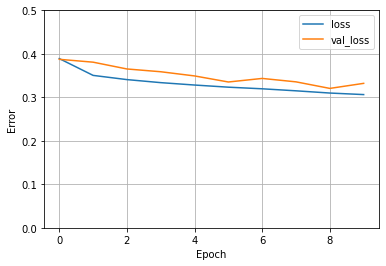

In [119]:
plot_loss(history)

In [ ]:
# df_subset = df.sample(n=X_train.size, random_state=42, replace=False)
# X_subset, y_subset = df_subset.drop("Severity", axis=1), df_subset["Severity"]
# X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=0)
# X_subset_train, X_subset_val, y_subset_train, y_subset_val = train_test_split(X_subset_train, y_subset_train, test_size=0.2, random_state=0)